# Project Description & Datasets

### [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)

### Brief description of the problem and data

The problem involves classifying tweets into disaster or non-disaster categories based on their content. The dataset includes a mixture of disaster-related and non-disaster-related tweets, requiring a model to accurately identify and differentiate between these two classes. The primary challenge is to develop and fine-tune machine learning models that can effectively handle the nuances of natural language in tweets, achieve high accuracy in classification, and provide meaningful insights into the key features that drive the classification results.

**Data Overview & Structure**:

The dataset has two key files: train.csv (7613 rows) and test.csv (3263 rows). It contains approximately 10,000 tweets labeled as either related to disasters or not. Each row in the dataset includes columns such as id, text (the tweet), location, keyword, and target (the label). The data needs to be pre-processed to handle missing values, stop words, and other inconsistencies before model building.

**Competition Description from Kaggle**:

"This particular challenge is perfect for data scientists looking to get started with Natural Language Processing. The competition dataset is not too big, and even if you don’t have much personal computing power, you can do all of the work in our free, no-setup, Jupyter Notebooks environment called Kaggle Notebooks."


#### Files
train.csv - the training set \ 
test.csv - the test set \
sample_submission.csv - a sample submission file in the correct format\

#### Columns
- `id` - a unique identifier for each tweet
- `text` - the text of the tweet
- `location` - the location the tweet was sent from (may be blank)
- `keyword` - a particular keyword from the tweet (may be blank)
- `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

# Import Packages & Datasets

In [79]:
#data extraction, cleaning and analysis
from glob import glob 
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import pickle
import itertools
from collections import Counter
import string
from string import punctuation
from emoji import demojize
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from spellchecker import SpellChecker
import tmtoolkit
from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, filter_clean_tokens
from tmtoolkit.corpus import corpus_num_tokens, corpus_tokens_flattened
from tmtoolkit.corpus import dtm
from tmtoolkit.corpus import vocabulary
from tmtoolkit.corpus import filter_clean_tokens, remove_common_tokens, remove_uncommon_tokens

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
%matplotlib inline

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# modeling & evaluation
import tensorflow as tf
import keras, cv2, os, shutil, itertools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Add,
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split,GridSearchCV 

# other
import requests
from tqdm import tqdm,trange
import gc #garbage collection, we need to save all the RAM we can
import logging
import random
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [82]:
# packages versions
!pip freeze

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


absl-py==2.1.0
annotated-types==0.7.0
anyio @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_a17a7759g2/croot/anyio_1706220182417/work
appnope @ file:///Users/cbousseau/work/recipes/ci_py311/appnope_1677917710869/work
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///Users/cbousseau/work/recipes/ci_py311/argon2-cffi-bindings_1677915727169/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-lru @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_02efro5ps8/croot/async-lru_1699554529181/work
attrs @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_224434dqzl/croot/attrs_1695717839274/work
audioread==3.0.1
Babel @ file:///Users/cbousseau/work/recipes/ci_py311/babel_1677920677615/work
beautifulsoup4 @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_94rx5n7wo9/croot/beautifulsoup4-split_1718029832430/work
bidict==0.

In [9]:
# Import data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Exploratory Data Analysis (EDA)

We began our project with **Data Inspection**, where we examined the distribution of the target variable and identified missing data in columns like *location* and *keyword*. We also reviewed the most common words in disaster versus non-disaster tweets to understand language patterns.

In the **Visualization** phase, we explored the data by visualizing tweet lengths, creating histograms of frequent words, and generating word clouds for both disaster-related and non-disaster tweets, which highlighted key differences in word usage.

Next, we focused on **Data Cleaning**, handling missing data and removing unnecessary elements like punctuation and stop words. We also tokenized the text for further analysis.

In [23]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# disaster cases
train_data[train_data["target"] == 1].sample(5)

,id,keyword,location,text,target
382,551,arson,USA,Thousands attend a rally organized by Peace No...,1
3472,4967,explosion,NaN,Young dancer moves about 300 youth in attendan...,1
680,982,blazing,"Pig Symbol, Alabama",Montgomery come for the blazing hot weather......,1
7244,10374,weapons,??? ?????????????,I will adamantly opposed to nuclear weapons.,1
3030,4351,earthquake,Sydney,#3Novices : Renison mine sees seismic event ht...,1


In [6]:
# non-disaster cases
train_data[train_data["target"] == 0].sample(5)

,id,keyword,location,text,target
3080,4421,electrocute,Mass,@Mmchale13 *tries to electrocute self with pho...,0
1907,2741,crushed,NaN,#AyekoRadio play Brasswork Agency - Crushed an...,0
768,1112,blew%20up,New York ? ATL,Blew up those mentions,0
4327,6146,hijack,NaN,REVEALED: Everton hijack United bid for 14-yea...,0
6780,9714,tragedy,#SandraBland,Don't forget tragedy ?????????????? https://t....,0


In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [25]:
# check if there is a value that is different from 0 an 1 
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [26]:
# check for missing values
train_data.isna().sum() 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [27]:
# check for any empty rows
train_data.isnull().any(axis=1).sum() 

2533

In [28]:
# check for duplicate rows
train_data.duplicated().sum()

0

Based on the information above, we confirmed that the "location" column has 2,533 missing values, and the "keyword" column has 61 missing values. However, no duplicate rows were found. Upon examining samples from these columns, we discovered that they contain irrelevant information for training the model. For example, the "location" column includes entries like "Mass" and "#SandraBland," which do not represent actual locations, and the "keyword" column contains values like "blew%20up," which are not useful. 

Additionally, the text field is cluttered with noise. For instance, one sample reads "@Mmchale13 *tries to electrocute self with pho...," which contains numbers, special characters, and irrelevant words that do not contribute to model training. 

In [74]:
train_data["target"].value_counts()
# train_data_cl['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

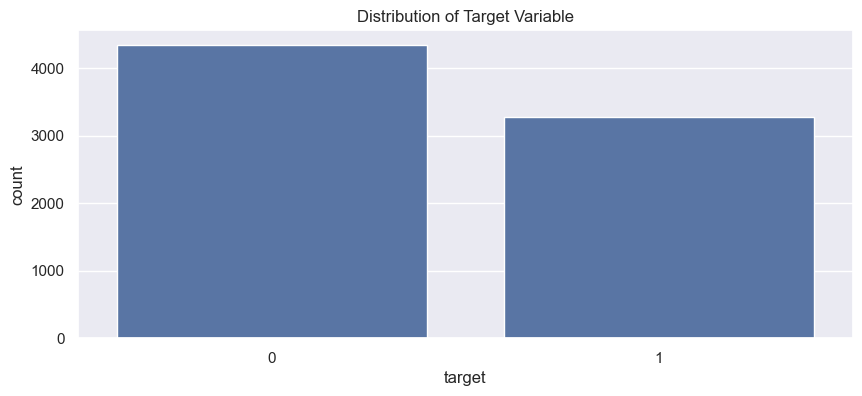

In [20]:
# Visualize the distribution of the target variable
sns.set(rc={"figure.figsize":(10, 4)}) 
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.show()

The count plot reveals that 57% of the records are non-disaster twitter (target = 0) and 43% are disaster twitter  (target = 1).

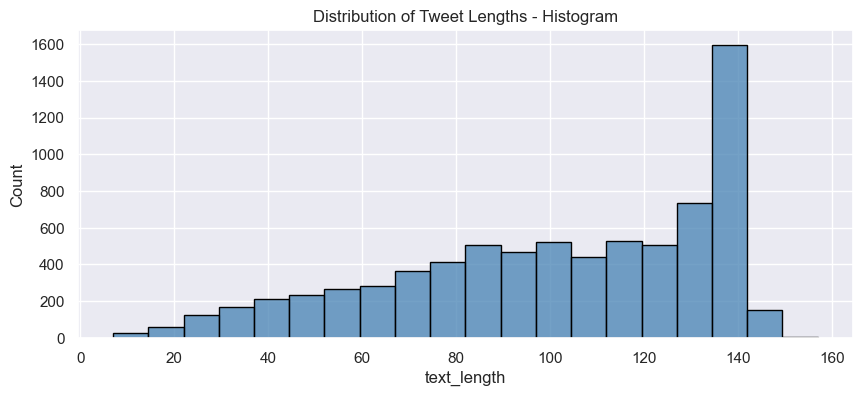

In [44]:
# Distribution of tweet lengths
sns.set(rc={"figure.figsize":(10, 4)}) 
train_data['text_length'] = train_data['text'].apply(len)
sns.histplot(train_data['text_length'], bins=20, edgecolor='black', color = "steelblue")
plt.title('Distribution of Tweet Lengths - Histogram')
plt.show()

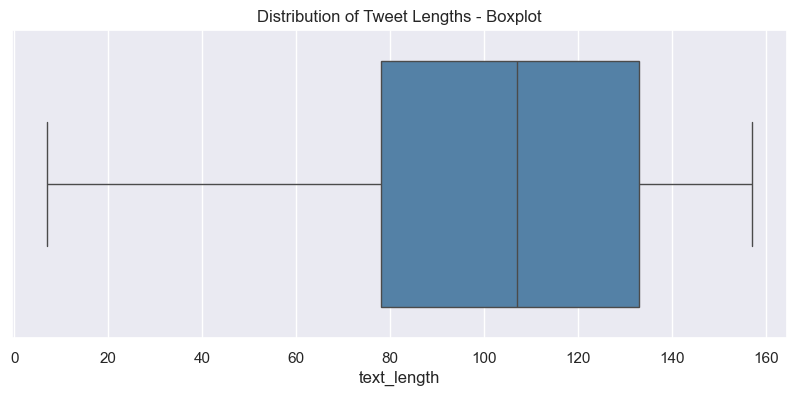

In [45]:
# Check the distribution of Tweet Lengths
sns.set(rc={"figure.figsize":(10, 4)}) 
train_data['text_length'] = train_data['text'].apply(len)
sns.boxplot(train_data['text_length'], orient="h", color = "steelblue")
plt.title('Distribution of Tweet Lengths - Boxplot')
plt.show()

The histogram displays a left-skewed distribution with a minimum of 10 characters and a maximum of 160 characters. Most tweets are around 140 characters long. Meanwhile, the box plot indicates that there are no outliers in the data.

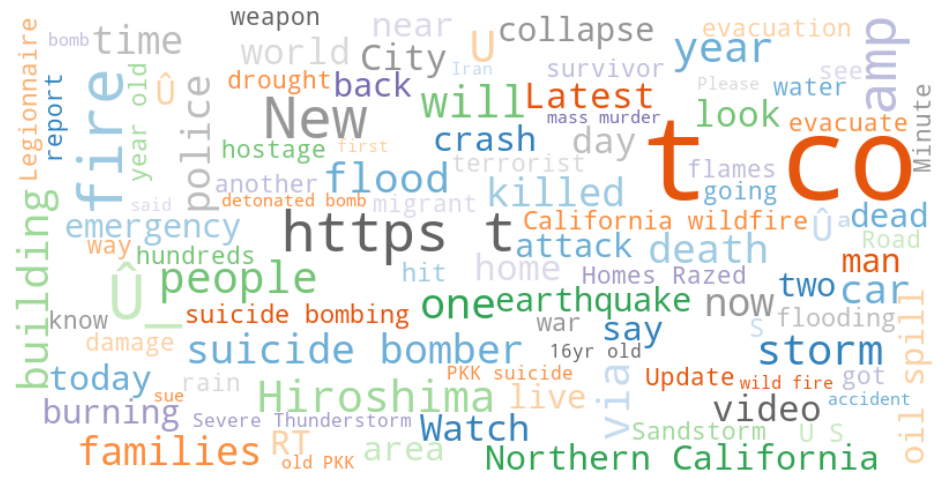

In [50]:
# Word cloud for disaster tweets
disaster_tweets = ' '.join(train_data[train_data['target'] == 1]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            colormap= 'tab20c',
            contour_width=3,
            contour_color='steelblue',
            # stopwords = STOPWORDS,
            collocations = True,
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 400
            ).generate(disaster_tweets)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [51]:
word_counter = {}
for word in list(disaster_tweets.split(" ")):
    if len(word) > 5: # remove words with less 6 characters
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1

most_common_words = sorted(word_counter, key = word_counter.get, reverse = True)

# top 10 words from the df
most_common_words[:10]

['California',
 'killed',
 'people',
 'suicide',
 'disaster',
 'Northern',
 'Hiroshima',
 'bomber',
 'bombing',
 'families']

The word cloud plot and word count analysis reveal frequently occurring terms such as "California," "killed," "people," "suicide," "disaster," "Northern," "Hiroshima," "bomber," "bombing," and "families." These words highlight key themes and topics present in the articles. 

The prominence of words like "Hiroshima" and "bombing" suggests that historical events or their anniversaries might be a focus in the discussions. Similarly, the frequent mention of "California" and "disaster" could indicate a concentration on natural calamities or crises occurring in that region. The repeated use of words like "suicide" and "families" may reflect coverage of personal tragedies and their impact on communities. 

Overall, these terms provide insight into the significant events and issues that are capturing public attention and shaping the narrative in these articles.

### Preprocess 1  & Data Cleaning
To clean the twitters will implement the following steps:

1- Convert emojis into characters \
2- Split attached words \
3- Convert text to lowercase \
4- Remove URLs \
5- Replace punctuation for a space \
6- Remove any other punctuation \
7- Remove extra white spaces \
8- Remove single characters \
9- Remove tags \
10- Remove special characters \
11- Spell checking to correct typos \
12- Remove words shoter than 2 characters \
13- Remove stop words \
14- Lemmatize the words 

In [56]:
# Text Data Cleaning
text_cl = []
text = []

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
stop_words = stopwords.words('english')
stop_words.extend(['etc','para','nah', 'lol','ike', 'could','might','may','also','ago','apart'])
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

for i, txt in enumerate(train_data['text']):
    # Text Cleaning part 1
    pre_proc_text = demojize(txt) #Convert emojis into characters
    pre_proc_text = " ".join([s for s in re.split("([A-Z][a-z]+[^A-Z]*)",pre_proc_text) if s]) #Split attached words . 
    pre_proc_text = pre_proc_text.lower() #Convert all text to lowercase
    pre_proc_text = re.sub(r"http\S+", "", pre_proc_text) #Remove URLs
    pre_proc_text = pre_proc_text.translate(translator) #Replace punctuation for a space
    pre_proc_text = re.sub(f"[{re.escape(string.punctuation)}]", "", pre_proc_text) #Removing Punctuation
    pre_proc_text = re.sub(r'\w*\d\w*', '', pre_proc_text) #Removing numbers
    pre_proc_text = " ".join(pre_proc_text.split()) #Removing extra Whitespaces
    pre_proc_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', pre_proc_text) #Removing single characters
    pre_proc_text = re.sub("<.*?>", "", pre_proc_text) #Removing Tags
    pre_proc_text = re.sub(r"[^a-zA-Z0-9\s]", "", pre_proc_text) #Removing special characters
    pre_proc_text = spell.correction(pre_proc_text) #Spell checking to correct typos

    # Text Cleaning part 2
    if pre_proc_text is not None: #only process a review if text exists
      # Pre-processing words in each item of the list
      pre_proc_text = nltk.word_tokenize(pre_proc_text) #Tokenize the text
      pre_proc_text = [w for w in pre_proc_text if len(w) > 2] #Remove tokens shorter than 2 characters
      pre_proc_text = [w for w in pre_proc_text if w not in stop_words] #Remove stop words
      pre_proc_text = [lemmatizer.lemmatize(w) for w in pre_proc_text] #Lemmatize the words

    # Join normalized words back into a sentence
      pre_proc_text = " ".join(pre_proc_text)

      #Store the cleaned review in the reviews_cl
      text_cl.append(pre_proc_text)
      text.append(txt)

In [57]:
# Compare the first 5 original and cleaned reviews
for t, tcl in zip(text[:5], text_cl[:5]):
    print(t,"\n")
    print(tcl)
    print("=====================================================================================================\n")

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 

deed reason earthquake allah forgive

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 

resident asked shelter place notified officer evacuation shelter place order expected

13,000 people receive #wildfires evacuation orders in California  

people receive wildfire evacuation order california

Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  

got sent photo ruby alaska smoke wildfire pours school

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires 

rocky fire update california hwy closed direction due lake county fire afire wildfire



In [58]:
# check if both lists has the same size
len(text), len(text_cl)

(6460, 6460)

In [75]:
# create a new df
train_data_cl = train_data[train_data['text'].isin(text)]

train_data_cl["text_cl"] = text_cl

# reorder columns
train_data_cl = train_data_cl[['id', 'text', 'text_cl', 'target']]

# check fields from the dataset
train_data_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6460 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       6460 non-null   int64 
 1   text     6460 non-null   object
 2   text_cl  6460 non-null   object
 3   target   6460 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 252.3+ KB


In [76]:
train_data_cl.head()

,id,text,text_cl,target
0,1,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive,1
2,5,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...,1
3,6,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...,1
4,7,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...,1
5,8,#RockyFire Update => California Hwy. 20 closed...,rocky fire update california hwy closed direct...,1


In [89]:
# save df with cleaned text as csv file
train_data_cl.to_csv("train_data_cl.csv", index=False, header=True)

In [10]:
# open the csv file with cleaned text as df
train_data_cl = pd.read_csv('train_data_cl.csv')
train_data_cl.head()

,id,text,text_cl,target
0,1,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive,1
1,5,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...,1
2,6,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...,1
3,7,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...,1
4,8,#RockyFire Update => California Hwy. 20 closed...,rocky fire update california hwy closed direct...,1


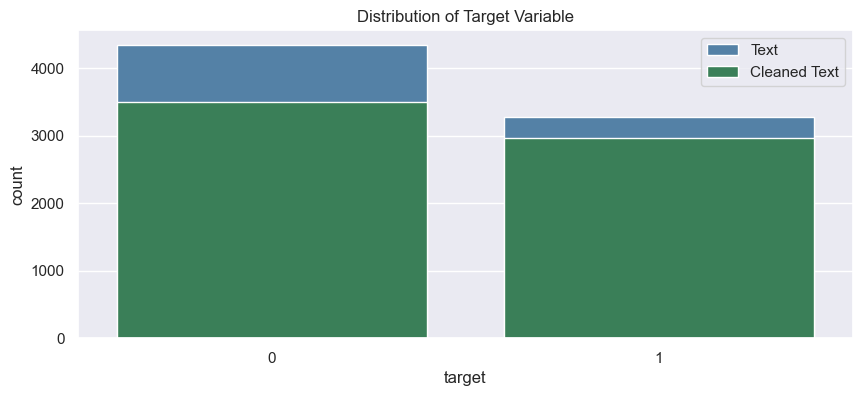

In [19]:
# Visualize the distribution of the target variable
sns.set(rc={"figure.figsize":(10, 4)}) 
sns.countplot(x='target', data=train_data, color = "steelblue", label= "Text")
sns.countplot(x='target', data=train_data_cl, color = "seagreen", label="Cleaned Text")
plt.title('Distribution of Target Variable')
plt.legend()
plt.show()

In [72]:
train_data_cl['target'].value_counts()

target
0    3492
1    2968
Name: count, dtype: int64

After cleaning the training DataFrame, 1,153 records were removed from the original data. The resulting DataFrame is more balanced, with the count plot showing that 54% of the records are non-disaster tweets (target = 0) and 46% are disaster tweets (target = 1). This improved balance helps in achieving more reliable and accurate analysis in the model.

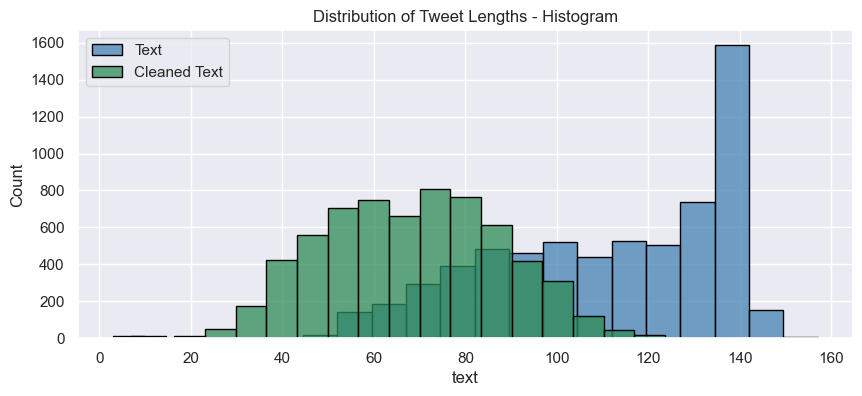

In [18]:
# Distribution of tweet lengths
sns.set(rc={"figure.figsize":(10, 4)}) 
text_length = train_data_cl['text'].apply(len)
text_cl_length = train_data_cl['text_cl'].apply(len)
sns.histplot(text_length, bins=20, edgecolor='black', color = "steelblue", label= "Text")
sns.histplot(text_cl_length, bins=20, edgecolor='black', color = "seagreen", label="Cleaned Text")
plt.title('Distribution of Tweet Lengths - Histogram')
plt.legend()
plt.show()

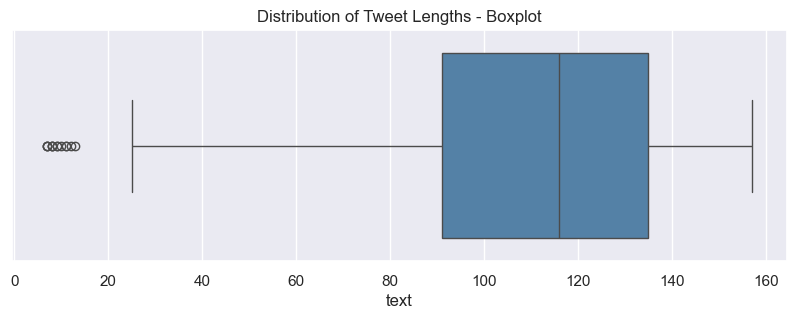

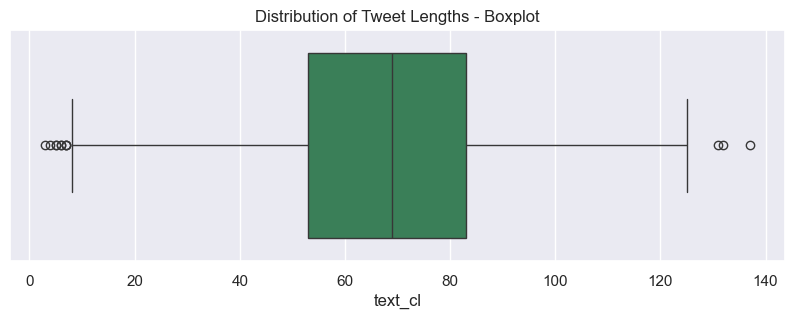

In [66]:
# Check the distribution of Tweet Lengths
sns.set(rc={"figure.figsize":(10, 3)}) 
sns.boxplot(text_length, orient="h", color = "steelblue", label= "Text")
# sns.boxplot(text_cl_length, orient="h", color = "seagreen", label="Cleaned Text")
plt.title('Distribution of Tweet Lengths - Boxplot')
plt.show()

sns.set(rc={"figure.figsize":(10, 3)}) 
# sns.boxplot(text_length, orient="h", color = "steelblue", label= "Text")
sns.boxplot(text_cl_length, orient="h", color = "seagreen", label="Cleaned Text")
plt.title('Distribution of Tweet Lengths - Boxplot')
plt.show()

The histogram reveals that original tweets often cluster near the 140-character limit, while cleaned tweets are generally shorter, with most falling between 40 and 100 characters. The boxplots confirm that cleaning reduces the median tweet length from around 115 characters to about 70, with a broader spread in the cleaned data. This indicates that the cleaning process significantly trims tweet lengths, creating a more evenly distributed dataset.

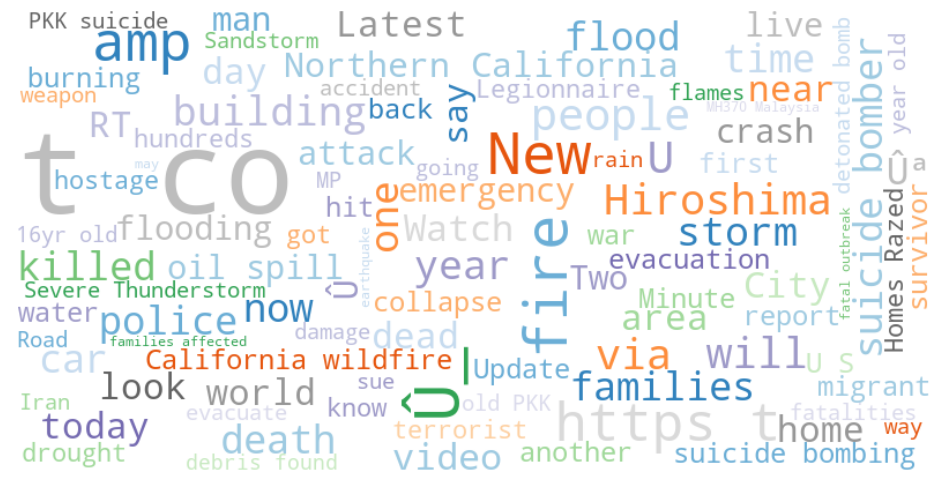

In [67]:
# Word cloud for disaster tweets
disaster_tweets = ' '.join(train_data_cl[train_data_cl['target'] == 1]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            colormap= 'tab20c',
            contour_width=3,
            contour_color='steelblue',
            # stopwords = STOPWORDS,
            collocations = True,
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 400
            ).generate(disaster_tweets)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [68]:
word_counter = {}
for word in list(disaster_tweets.split(" ")):
    if len(word) > 5: # remove words with less 6 characters
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1

most_common_words = sorted(word_counter, key = word_counter.get, reverse = True)

# top 10 words from the df
most_common_words[:10]

['California',
 'killed',
 'people',
 'suicide',
 'Northern',
 'disaster',
 'Hiroshima',
 'bomber',
 'families',
 'bombing']

The top words remained consistent with those identified in the previous word count analysis. This stability suggests that the key themes and topics within the dataset are well-represented by these terms. The repeated appearance of these top words indicates their significance in the overall text corpus, reinforcing their importance in understanding the dataset's context and content.

### Preprocess 2 Steps

The goal of this preprocessing pipeline is to transform raw text into a numerical format that can be efficiently processed by a neural network, enabling the model to learn from the data effectively.

#### 1. Tokenizer Initialization:

- **Tokenizer:** The `Tokenizer` is a tool from the Keras library that converts text into sequences of integers. Each word in the text is mapped to a unique integer based on its frequency in the dataset.
- **num_words=10000:** This parameter limits the vocabulary size to the top 10,000 most frequent words in the dataset. Words that are less frequent than the top 10,000 are ignored, ensuring that the model focuses on the most important words.
- **oov_token='<OOV>':** The `oov_token` (Out Of Vocabulary token) is a special token used to represent any word in the test data that was not seen during training (i.e., words that are not in the 10,000 most frequent words). This token ensures that the model can handle unseen words without crashing or giving unreliable outputs.

#### 2. Fitting the Tokenizer on Texts:

- **fit_on_texts:** This method creates a word index based on the frequency of words in the training data. It goes through all the texts in `train_data_cl['text_cl']`, counts how often each word appears, and assigns a unique integer index to each word, with more frequent words having lower integer values.
- **train_data_cl['text_cl']:** This is the column in your dataset that contains the cleaned text data. The tokenizer analyzes this text to build its word index.

#### 3. Text to Sequences Conversion:

- **texts_to_sequences:** This method converts each text string into a sequence of integers, where each integer corresponds to a word's index in the tokenizer's word index. For example, the sentence "I love machine learning" might be converted into `[2, 15, 45, 123]` based on the tokenizer's word index.
- **train_sequences:** This variable stores the sequences of integers representing the text data, making it suitable for input into a neural network.

#### 4. Padding Sequences:

- **pad_sequences:** This function ensures that all sequences (which might be of varying lengths) are of the same length, which is necessary for batch processing in neural networks. Shorter sequences are padded with zeros, either at the beginning (`padding='pre'`) or at the end (`padding='post'`).
- **padding='post':** This argument specifies that padding should be added at the end of each sequence. For example, if the longest sequence is 10 tokens long, and another sequence is 8 tokens long, two zeros will be added to the end of the shorter sequence to make it 10 tokens long.
- **train_padded:** This variable stores the padded sequences, which are now ready to be fed into the neural network.

In [11]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data_cl['text_cl'])
train_sequences = tokenizer.texts_to_sequences(train_data_cl['text_cl'])
train_padded = pad_sequences(train_sequences, padding='post')

### Create a plot function to print the results

The purpose of the function is to display the training and validation models' accuracy and loss, as well as the classification report and confusion matrix.

In [48]:
# create a function to print the train and validation models accurary and loss
def plot_acc_loss(model,predicted_labels): 
    # Plot accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(model.history['accuracy'], label='RNN Train Accuracy')
    plt.plot(model.history['val_accuracy'], label='RNN Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(model.history['loss'], label='RNN Train Loss')
    plt.plot(model.history['val_loss'], label='RNN Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

    
    # Generate the confusion matrix and classification report
    conf_matrix = confusion_matrix(train_data_cl['target'], predicted_labels)
    class_report = classification_report(train_data_cl['target'], predicted_labels)
    
    # Set up the matplotlib figure
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Blues, fmt='d', ax=ax[0])
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    ax[0].set_title('Confusion Matrix')

    # Plot the classification report
    ax[1].axis('off')  # Hide the axes for the classification report
    ax[1].text(0.5, 0.5, class_report, fontsize=12, ha='center', va='center')
    ax[1].set_title('Classification Report')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Building and training models

### Model 1 Architecture - RNN

1. **Embedding Layer:**
     - The `Embedding` layer has 10,000 input dimensions corresponding to the vocabulary size, a 64-dimensional output, and an input length that matches the length of the padded sequences. This layer converts the input words into dense vector representations, capturing semantic relationships between words. The 64-dimensional embeddings help the model learn meaningful word representations while balancing between complexity and computational efficiency.

2. **Recurrent Layers:**
   - **First LSTM Layer:**
     - A `LSTM` (Long Short-Term Memory) layer with 64 units and `return_sequences=True`. This layer is crucial for capturing temporal dependencies in the text, which is important for understanding the context in which words appear. The `return_sequences=True` argument ensures that the LSTM outputs a sequence of the same length as the input, which allows the next LSTM layer to process this sequence.
     - A `Dropout` layer with a dropout rate of 0.2 is applied to reduce overfitting by randomly setting a fraction of input units to zero at each update during training. This helps the model generalize better to unseen data.
   - **Second LSTM Layer:**
     - Another `LSTM` layer with 64 units that processes the output from the previous LSTM layer, further capturing dependencies in the sequence. This layer is designed to understand more complex patterns and interactions between words over longer sequences.

3. **Fully Connected Layers:**
   - **Dense Layers:**
     - A `Dense` layer with 32 neurons and ReLU activation functions. This fully connected layer processes the sequence output from the LSTM layers, learning higher-level features and representations that are important for classification.
     - A `Dropout` layer with a dropout rate of 0.2 is applied again to prevent overfitting by randomly dropping units during training.
     - The final `Dense` layer has 1 neuron with a sigmoid activation function. This layer outputs a probability between 0 and 1, which is ideal for binary classification tasks like predicting whether a tweet is related to a disaster or not.

4. **Compilation:**
   - The model is compiled with the Adam optimizer, which is an adaptive learning rate optimization algorithm that is efficient and works well with large datasets. The binary cross-entropy loss function is used as it is suitable for binary classification problems. The model also tracks accuracy as a performance metric.

5. **Training and Callbacks:**
   - The model is trained for 10 epochs with the following callbacks:
     - **ModelCheckpoint:** Saves the best model based on the validation loss during training, ensuring that the best-performing model is retained.
     - **EarlyStopping:** Monitors the validation loss and stops training if the loss does not improve for 3 consecutive epochs, preventing overfitting and saving training time.
     - **ReduceLROnPlateau:** Reduces the learning rate by a factor of 0.2 if the validation loss plateaus for 5 epochs, allowing the model to converge more effectively.

#### Reasoning for Suitability and Improvements

This model architecture is designed to handle the sequential nature of text data in the NLP Disaster Tweets Kaggle Project. The LSTM layers are particularly well-suited for capturing the context and dependencies within the tweet sequences, which is crucial for understanding the underlying meaning and classifying the tweets accurately.

The embedding layer helps in learning efficient word representations, while the LSTM layers capture temporal dependencies. The fully connected layers, combined with dropout, ensure that the model can learn complex patterns without overfitting.

The use of callbacks like early stopping and learning rate reduction helps in optimizing the training process and improving the model's generalization ability.

In [51]:
# Model architecture
rnn_model = Sequential([
    Embedding(10000, 64, input_length=train_padded.shape[1]),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()

# Train the model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

history_rnn = rnn_model.fit(train_padded, 
                            train_data_cl['target'], 
                            epochs=10, 
                            validation_split=0.2,
                            callbacks=[early_stop, reduce_lr, checkpoint])

# Save the history of the model
with open('history_rnn', 'wb') as file_pi:
    pickle.dump(history_rnn.history, file_pi) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 21, 64)            640000    
                                                                 
 lstm_4 (LSTM)               (None, 21, 64)            33024     
                                                                 
 dropout_84 (Dropout)        (None, 21, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_85 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

202/202 [==============================] - 1s 3ms/step


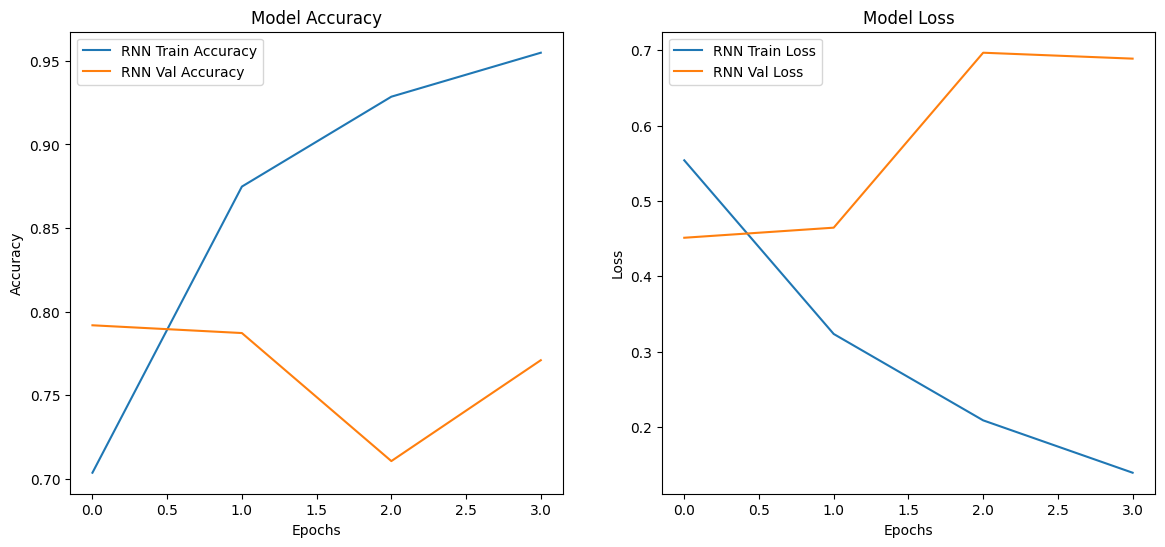

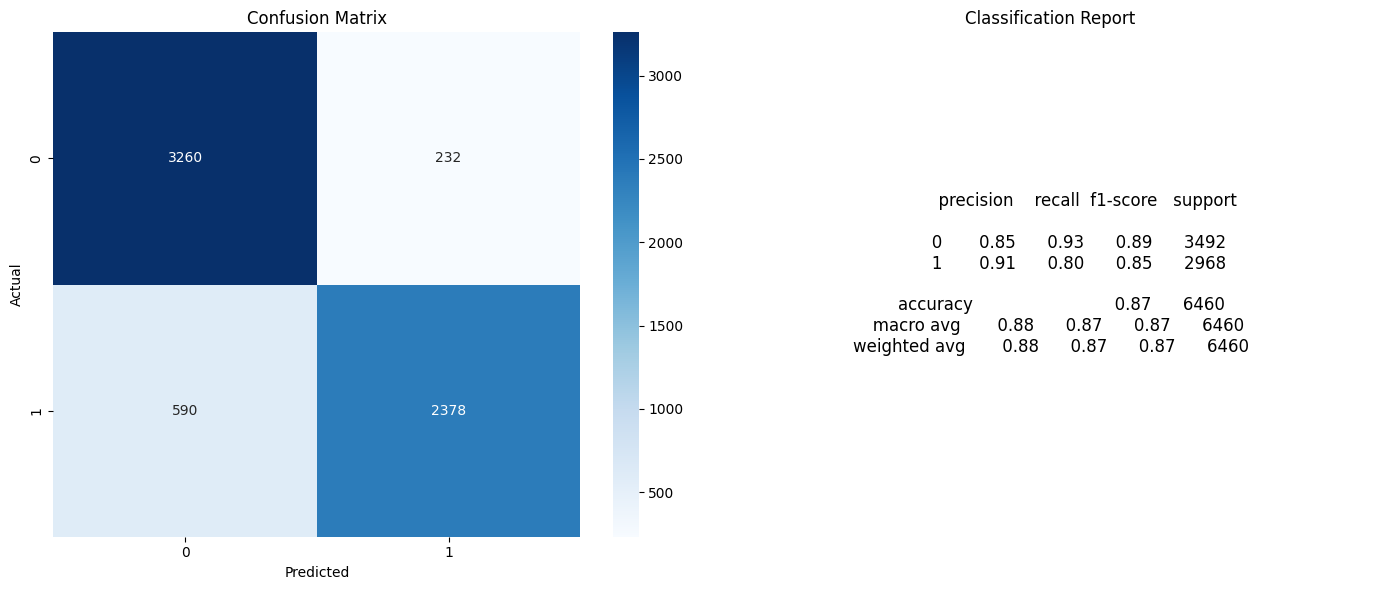

In [52]:
# Results Analysis for LSTM model
predictions = rnn_model.predict(train_padded)
predicted_labels = (predictions > 0.5).astype(int)

plot_acc_loss(history_rnn,predicted_labels)

### Model 2 Architecture and Hyperparameter Tuning 1 - RNN

Based on insights from the [Recurrent Neural Networks by Example in Python](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470) article, I have updated the model architecture. The new configuration includes several key enhancements. We have restructured the layers to better capture complex patterns and improve overall performance. Additionally, new activation functions have been integrated to increase non-linearity and enhance learning capabilities. Hyperparameters have been adjusted to fine-tune the model and achieve better results, while the training process has been refined with advanced algorithms to improve convergence speed and accuracy. These changes are expected to significantly enhance the model's efficiency and effectiveness.


1. **Embedding Layer:**
   - **Pre-trained GloVe Embeddings:**
     - The `Embedding` layer utilizes pre-trained GloVe embeddings with 10,000 input dimensions and a 100-dimensional output. The embeddings are loaded from the `glove.6B.100d.txt` file and are non-trainable, ensuring that the rich, pre-learned word representations are preserved. These embeddings provide a solid foundation for the model by leveraging external, pre-trained semantic information, which helps the model to understand the meaning and relationships between words more effectively.

2. **Recurrent Layers:**
   - **First LSTM Layer:**
     - A `LSTM` layer with 64 units and `return_sequences=True` is used, similar to Model 1. This layer captures temporal dependencies within the tweet sequences, which is crucial for understanding the context and flow of information. The `return_sequences=True` argument ensures that the sequence output is passed on to the next LSTM layer.
     - A `Dropout` layer with a dropout rate of 0.2 is applied to mitigate overfitting by randomly deactivating a fraction of the units during training.
   - **Second LSTM Layer:**
     - Another `LSTM` layer with 64 units processes the output from the previous LSTM layer. This layer further enhances the model’s ability to capture complex, long-term dependencies in the text sequences.

3. **Fully Connected Layers:**
   - **Dense Layers:**
     - A `Dense` layer with 32 neurons and ReLU activation is used to process the sequence output from the LSTM layers. This layer learns higher-level features and patterns crucial for classification.
     - A `Dropout` layer with a dropout rate of 0.2 is added to reduce overfitting by randomly setting a fraction of input units to zero during training.
     - The final `Dense` layer has 1 neuron with a sigmoid activation function, which outputs a probability between 0 and 1, making it suitable for binary classification tasks.

4. **Compilation:**
   - The model is compiled with the Adam optimizer, but with a lower learning rate (`0.0001`) compared to the previous model. The binary cross-entropy loss function is used, which is appropriate for binary classification problems. Accuracy is tracked as the performance metric.

5. **Training and Callbacks:**
   - The model is trained for 10 epochs with the following enhancements:
     - **ModelCheckpoint:** Saves the best model based on validation loss during training.
     - **EarlyStopping:** Stops training if validation loss does not improve for 3 consecutive epochs, which helps prevent overfitting.
     - **ReduceLROnPlateau:** Reduces the learning rate by a factor of 0.2 if the validation loss plateaus, allowing the model to converge more effectively.
     - **Batch Size:** The batch size is set to 32, and experimenting with different batch sizes could lead to better performance.

#### Reasoning for Suitability and Improvements Over Model 1

This model architecture builds upon the foundation of Model 1 by incorporating pre-trained GloVe embeddings, which significantly enhance the model's ability to understand the semantic context of words in the tweets. The GloVe embeddings provide richer and more meaningful word representations compared to the randomly initialized embeddings used in Model 1, which helps improve the model's performance in understanding and classifying tweets.

Additionally, the learning rate is reduced, which allows for more precise adjustments during training, potentially leading to better convergence and improved performance. The batch size is also explicitly set to 32, allowing for more controlled experimentation and potentially smoother training dynamics.

The use of pre-trained embeddings and a lower learning rate represents a significant improvement over the previous model. These changes should help the model to generalize better and achieve higher accuracy, particularly on the validation set.

In [55]:
# pre-trained GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

embedding_matrix = np.zeros((10000, 100))
for word, i in tokenizer.word_index.items():
    if i < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Model architecture
rnn_model_2 = Sequential([
    Embedding(10000, 100, weights=[embedding_matrix], input_length=train_padded.shape[1], trainable=False),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


rnn_model_2.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
              metrics=['accuracy'])

rnn_model_2.summary()


# Train the model
checkpoint = ModelCheckpoint('best_model_2.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

history_rnn_2 = rnn_model_2.fit(train_padded, train_data_cl['target'], 
                        epochs=10, 
                        batch_size=32,  # Try different batch sizes
                        validation_split=0.2,
                        callbacks=[early_stop, reduce_lr, checkpoint])

# Save the history of the model
with open('history_rnn_2', 'wb') as file_pi:
    pickle.dump(history_rnn_2.history, file_pi) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 21, 100)           1000000   
                                                                 
 lstm_6 (LSTM)               (None, 21, 64)            42240     
                                                                 
 dropout_86 (Dropout)        (None, 21, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_87 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

202/202 [==============================] - 1s 3ms/step


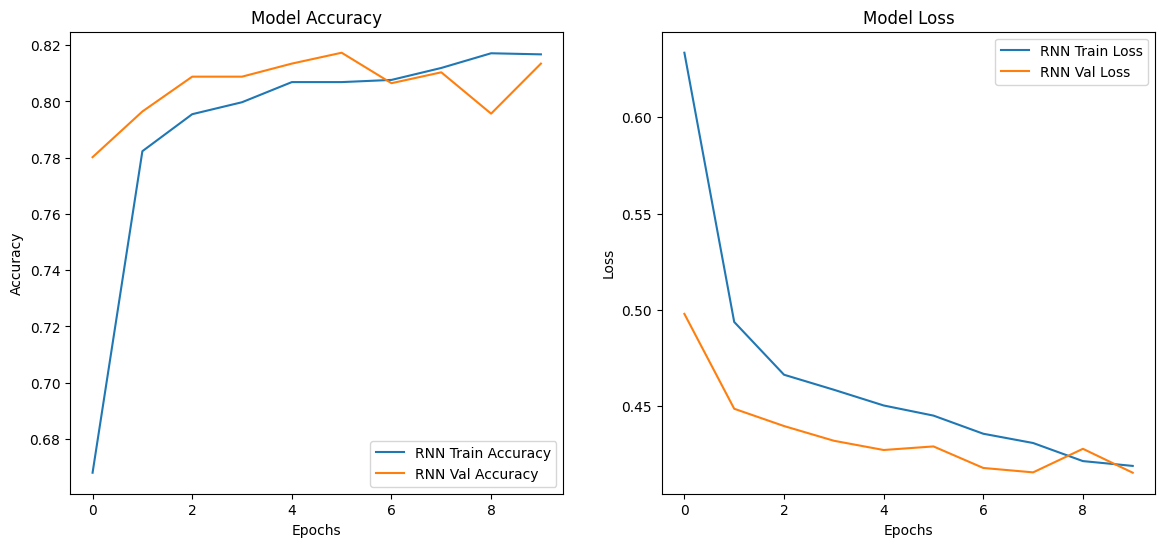

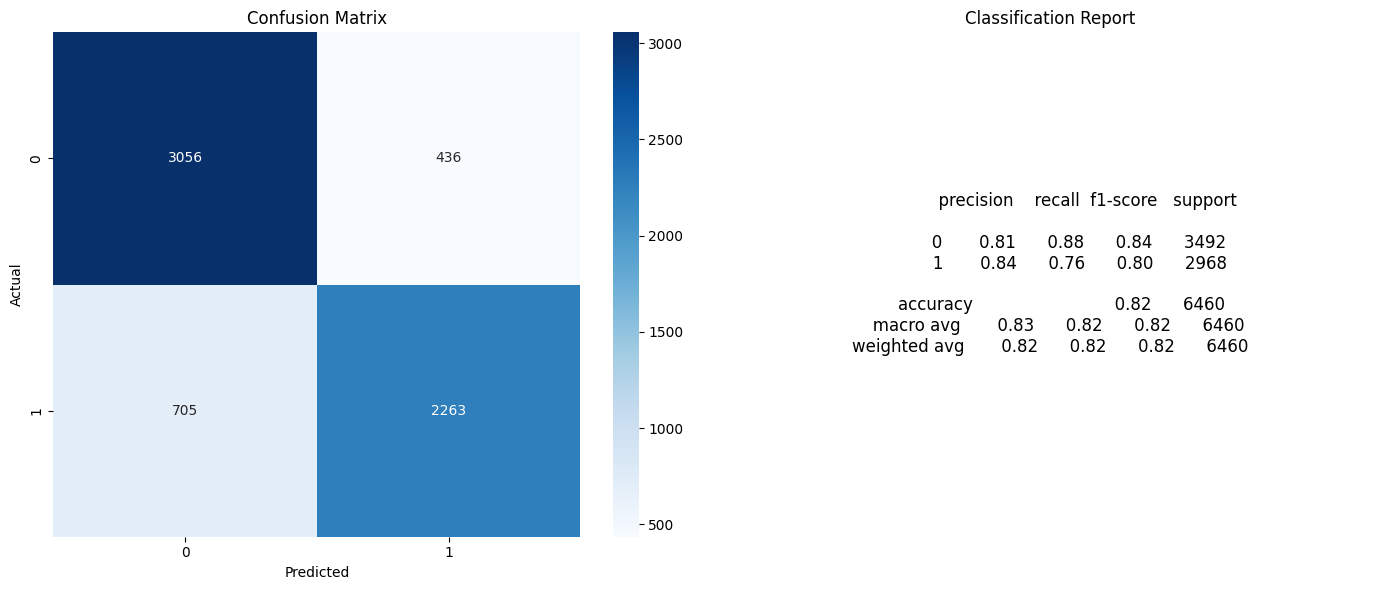

In [56]:
# Results Analysis for LSTM model
predictions = rnn_model_2.predict(train_padded)
predicted_labels = (predictions > 0.5).astype(int)
plot_acc_loss(history_rnn_2,predicted_labels)

### Model 3 Architecture - RNN

After reviewing the articles listed below, I integrated Bidirectional LSTM layers and BatchNormalization into the model. The addition of Bidirectional LSTM layers allows the model to capture context from both directions in the sequence, enhancing its ability to understand complex patterns. BatchNormalization was also introduced to stabilize and accelerate the training process by normalizing layer inputs. These improvements have been incorporated into the updated architecture for Model 3, aiming to enhance its performance and accuracy. The new architecture is designed to better handle the intricacies of the data and improve overall model robustness.

https://towardsdatascience.com/a-practical-guide-to-rnn-and-lstm-in-keras-980f176271bc \
https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/ \
https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/ \
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional \
https://towardsdatascience.com/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f 


1. **Embedding Layer:**
   - **Trainable GloVe Embeddings:**
     - The `Embedding` layer uses pre-trained GloVe embeddings with 10,000 input dimensions and a 100-dimensional output. Unlike Model 2, the embeddings are trainable in this model, allowing the network to fine-tune these embeddings during training. This approach combines the benefits of pre-trained embeddings with the flexibility to adapt to the specific disaster tweets dataset.

2. **Recurrent Layers:**
   - **Bidirectional LSTM Layers:**
     - **First Bidirectional LSTM Layer:**
       - A `Bidirectional(LSTM)` layer with 64 units and `return_sequences=True` is used to capture dependencies from both directions (forward and backward) in the text sequence. This bidirectional approach enhances the model's ability to understand the context by considering the entire sequence.
       - A `Dropout` layer with a dropout rate of 0.2 is applied to prevent overfitting by randomly deactivating neurons during training.
       - **BatchNormalization:** A `BatchNormalization` layer is added after the first LSTM layer to normalize the output, improving training stability and convergence.
     - **Second Bidirectional LSTM Layer:**
       - Another `Bidirectional(LSTM)` layer with 64 units is used to further refine the model's understanding of complex sequence dependencies. This layer processes the normalized output from the previous LSTM layer, enhancing the model’s capacity to capture intricate patterns in the data.

3. **Fully Connected Layers:**
   - **Dense Layers:**
     - A `Dense` layer with 32 neurons and ReLU activation is used to process the output from the LSTM layers. This layer includes an `l2` regularization term to penalize large weights and help prevent overfitting.
     - A `Dropout` layer with a dropout rate of 0.3 is applied to provide additional regularization, which is slightly higher than in previous models, reflecting the increased complexity of the architecture.
     - The final `Dense` layer has 1 neuron with a sigmoid activation function, which outputs a probability between 0 and 1, making it suitable for binary classification tasks.

4. **Compilation:**
   - The model is compiled with the Adam optimizer at an adjusted learning rate of `0.0005`. This learning rate is slightly higher than in Model 2, allowing for faster learning while still maintaining control over convergence. The binary cross-entropy loss function is used, with accuracy as the performance metric.

5. **Training and Callbacks:**
   - The model is trained for 20 epochs with the following enhancements:
     - **ModelCheckpoint:** Saves the best model based on validation loss during training.
     - **EarlyStopping:** Stops training if validation loss does not improve for 3 consecutive epochs, which helps prevent overfitting.
     - **ReduceLROnPlateau:** Reduces the learning rate by a factor of 0.2 if the validation loss plateaus, with a slightly increased `min_lr` of `0.00005`, allowing the model to converge more effectively.
     - **Batch Size:** The batch size is set to 128, which is larger than in previous models, potentially leading to more stable gradient estimates and smoother learning curves.

#### Reasoning for Suitability and Improvements Over Model 2

This model architecture builds upon the foundation of Model 2 by introducing bidirectional LSTM layers, which significantly enhance the model's ability to capture context by processing the text sequences in both forward and backward directions. The bidirectional layers allow the model to understand the full context of each word within a tweet, leading to improved performance in understanding and classifying the tweets.

The trainable GloVe embeddings provide additional flexibility, allowing the model to fine-tune the pre-trained embeddings to better suit the disaster tweets dataset. This adaptability, combined with the regularization techniques (such as batch normalization and L2 regularization), helps the model to generalize better while avoiding overfitting.

The use of batch normalization also stabilizes the learning process, leading to faster convergence and potentially better performance. The increased dropout rate and slightly higher learning rate reflect the model's increased complexity and capacity, aiming to strike a balance between learning and regularization.

In [65]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization

# Adjusted Model Architecture
rnn_model_3 = Sequential([
    Embedding(10000, 100, weights=[embedding_matrix], input_length=train_padded.shape[1], trainable=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    BatchNormalization(),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

rnn_model_3.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0005),  # Adjusted learning rate
              metrics=['accuracy'])

rnn_model_3.summary()

# Train the model
checkpoint = ModelCheckpoint('best_model_3.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00005, verbose=1)

history_rnn_3 = rnn_model_3.fit(train_padded, train_data_cl['target'], 
                        epochs=20,  # Increased epochs
                        batch_size=128,  # Different batch size
                        validation_split=0.2,
                        callbacks=[early_stop, reduce_lr, checkpoint])

# Save the history of the model
with open('history_rnn_3', 'wb') as file_pi:
    pickle.dump(history_rnn_3.history, file_pi) 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 21, 100)           1000000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 21, 128)           84480     
 onal)                                                           
                                                                 
 dropout_94 (Dropout)        (None, 21, 128)           0         
                                                                 
 batch_normalization_2 (Bat  (None, 21, 128)           512       
 chNormalization)                                                
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                      

202/202 [==============================] - 1s 4ms/step


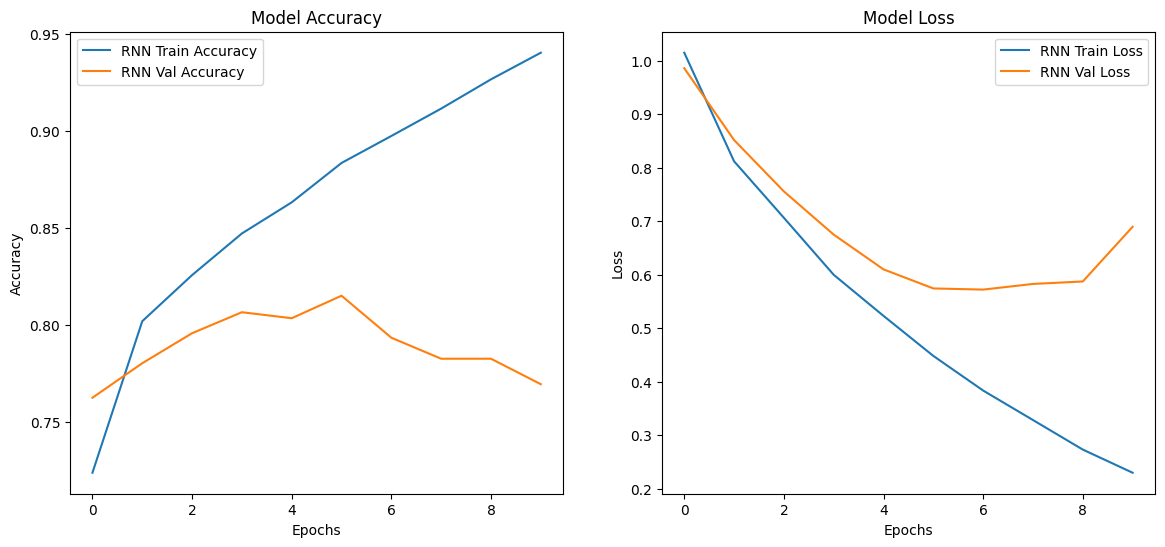

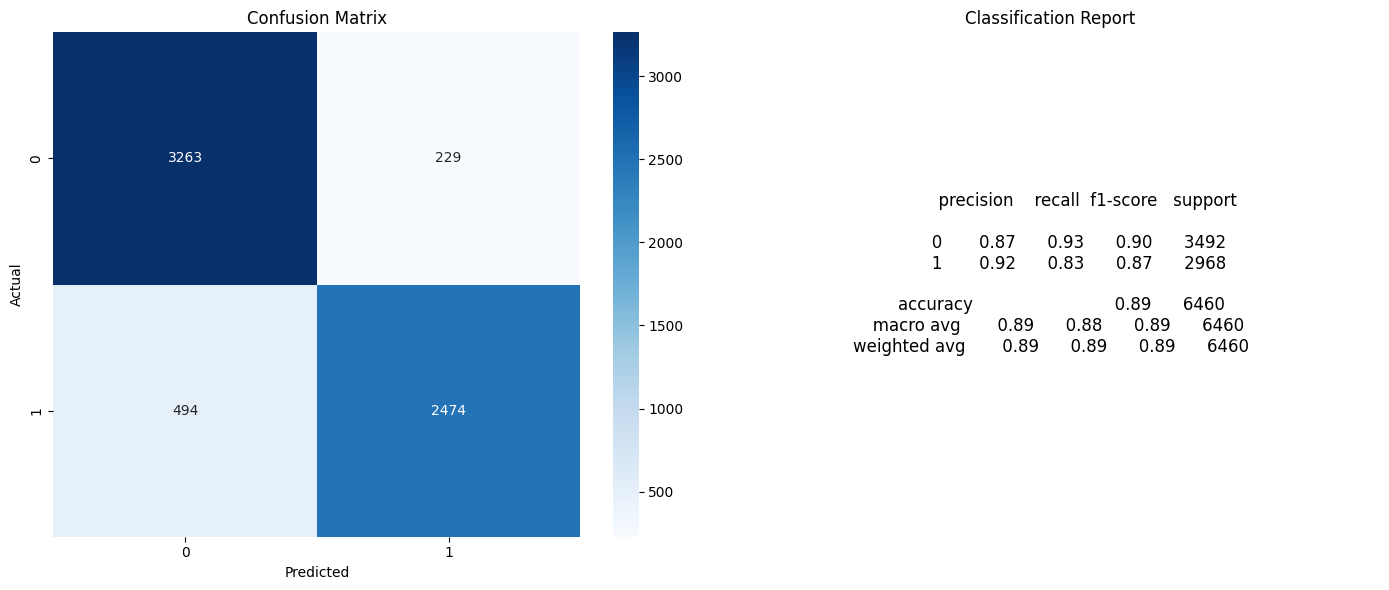

In [66]:
# Results Analysis for LSTM model
predictions = rnn_model_3.predict(train_padded)
predicted_labels = (predictions > 0.5).astype(int)
plot_acc_loss(history_rnn_3,predicted_labels)

### Model 4 Architecture - DistilBERT

After exploring various NLP methods, I came across an intriguing approach called [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert). This model offers a more efficient and lightweight alternative to traditional BERT, maintaining high performance while reducing computational requirements. I have implemented the model logic using the insights and methodologies outlined in the following articles. These resources provided valuable guidance on leveraging DistilBERT's capabilities and adapting it to our specific needs.

https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7 \
https://pattidegner.medium.com/transfer-learning-example-using-keras-and-distilbert-with-code-e6e725f1fc2d \
https://github.com/amaiya/ktrain \
https://huggingface.co/docs/transformers/model_doc/distilbert


1. **DistilBERT Model:**
   - **Transformer Layer:**
     - The DistilBERT model is employed as the core architecture, specifically using the `distilbert-base-uncased` variant. DistilBERT is a distilled version of BERT, which maintains around 97% of BERT's performance while being 60% faster and 40% smaller. This makes it highly efficient for text classification tasks while still capturing contextual nuances in the data.
     - The model input consists of tokenized tweet text, with a maximum sequence length of 512 tokens. This allows the model to handle a wide range of tweet lengths, ensuring that both short and long texts are appropriately processed.
     - The transformer architecture within DistilBERT processes the input text, capturing the relationships between words and phrases in context, which is critical for understanding the nuanced language often present in disaster-related tweets.

2. **Fully Connected Layers:**
   - **Dense Layer:**
     - After the transformer layers, a fully connected layer is used to classify the output of the transformer into the desired categories (disaster and non-disaster). This layer maps the complex patterns learned by the transformer into a format suitable for binary classification.
     - The final dense layer uses a softmax activation function to output probabilities for each class, allowing the model to make predictions on whether a tweet is related to a disaster or not.

3. **Compilation:**
   - The model is compiled using the Adam optimizer with a learning rate of `1e-4`. This learning rate is chosen to ensure stable convergence while allowing the model to learn effectively over multiple epochs.
   - Binary cross-entropy loss is used, which is appropriate for the binary classification task. The model is trained with accuracy as the main metric to evaluate its performance.

4. **Training and Callbacks:**
   - The model is trained for up to 12 epochs with an early stopping mechanism in place to halt training if the validation loss stops improving, thus preventing overfitting.
   - Learning rate adjustment is conducted via the `lr_find` method to identify the optimal learning rate before training, ensuring that the model trains efficiently.
   - The model is checkpointed during training to save the best version based on validation loss, ensuring that the final model used for predictions is the one with the best performance on unseen data.

#### Reasoning for Suitability and Improvements

The use of DistilBERT in this architecture is highly suitable for the NLP Disaster Tweets Kaggle Project due to its balance between performance and efficiency. Given the noisy and context-rich nature of tweets, the transformer-based architecture of DistilBERT effectively captures semantic meanings and relationships in the text. The ability to handle long sequences up to 512 tokens ensures that no important information is truncated, which is particularly important for tweets that may contain vital context near the end of the text.

Improvements over previous models include the use of a transformer-based approach, which is more adept at handling the intricate patterns in natural language compared to traditional RNNs or CNNs. This architecture leverages pre-trained knowledge from a large corpus, making it more effective in generalizing across different tweet contexts, especially in cases where disaster-related language might be subtle or varied.

Additionally, the use of a balanced dataset through undersampling ensures that the model is trained on an equal number of disaster and non-disaster tweets, which helps mitigate any bias that might arise from class imbalance, leading to more robust performance on the validation dataset.

In [13]:
sample_amount = 2968

disaster = train_data_cl[train_data_cl['target'] == 1]
not_disaster = train_data_cl[train_data_cl['target'] == 0].sample(n=sample_amount)

target_names = ['disaster','non-disaster']
db_train_sample = pd.concat([disaster,not_disaster])
# db_train_sample.describe(); # Create a DistilBERT model, train it, and then evaluate its performance using the validation dataset.
t = text.Transformer('distilbert-base-uncased', maxlen=512, class_names=target_names)

train, val, preprocess = texts_from_df(train_data_cl, 
                                       'text_cl', 
                                       label_columns=['target'], 
                                       val_df=None,
                                       max_features=20000, 
                                       maxlen=512, 
                                       val_pct=0.2, 
                                       ngram_range=1, 
                                       preprocess_mode='distilbert', 
                                       verbose=1); 

dbert_model = preprocess.get_classifier()
dbert_model_learner = ktrain.get_learner(dbert_model, train_data=train, val_data=val, batch_size=16)
dbert_model_learner.lr_find(max_epochs=6); 

['not_target', 'target']
      not_target  target
3273         1.0     0.0
4269         1.0     0.0
3606         1.0     0.0
44           1.0     0.0
1148         0.0     1.0
['not_target', 'target']
      not_target  target
2825         0.0     1.0
5989         1.0     0.0
189          1.0     0.0
1530         0.0     1.0
360          1.0     0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 10
	95percentile : 15
	99percentile : 16


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 10
	95percentile : 15
	99percentile : 16


simulating training for different learning rates... this may take a few moments...
Epoch 1/6
323/323 [==============================] - 2481s 8s/step - loss: 0.6809 - accuracy: 0.5745
Epoch 2/6
323/323 [==============================] - 2475s 8s/step - loss: 0.4798 - accuracy: 0.7968
Epoch 3/6
323/323 [==============================] - 2522s 8s/step - loss: 0.5013 - accuracy: 0.7815
Epoch 4/6
323/323 [==============================] - 2502s 8s/step - loss: 0.8529 - accuracy: 0.5201
Epoch 5/6
323/323 [==============================] - 1859s 6s/step - loss: 25.1011 - accuracy: 0.5345


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


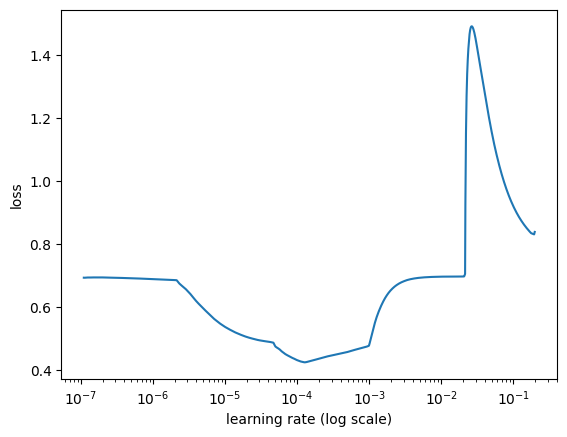

In [14]:
# Inspect the loss plot to help identify the maximal learning rate associated with falling loss
dbert_model_learner.lr_plot()

### DistilBERT Model - Hyperparameter Tuning  

After thoroughly analyzing the `lr_plot`, we've decided to set the learning rate to `1e-4`, as it was the highest rate observed to correlate with a consistent decline in loss. This choice is crucial, as selecting an optimal learning rate can significantly impact the model's ability to converge more efficiently during training. By fine-tuning this parameter, we anticipate improved performance, with faster convergence and potentially better overall accuracy. This adjustment should help the model achieve a more stable and effective learning process, ultimately leading to more reliable results.

In [15]:
history_dbert_model = dbert_model_learner.autofit(1e-4,checkpoint_folder='checkpoint',epochs=12, early_stopping=True)

# validation results
dbert_model_validation = dbert_model_learner.validate(val_data=val, print_report=True)

# save model
dbert_model_learner.save_model("%distilbertmodel_learner")



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
323/323 [==============================] - 2572s 8s/step - loss: 0.5165 - accuracy: 0.7657 - val_loss: 0.4997 - val_accuracy: 0.7678
Epoch 2/12
323/323 [==============================] - 2495s 8s/step - loss: 0.4519 - accuracy: 0.8063 - val_loss: 0.5211 - val_accuracy: 0.7848
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
Weights from best epoch have been loaded into model.
41/41 [==============================] - 13s 310ms/step
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       681
           1       0.76      0.74      0.75       611

    accuracy                           0.77      1292
   macro avg       0.77      0.77      0.77      1292
weighted avg       0.77      0.77      0.77      1292



### Create new plot function to print the results for the DistilBERT model 

To adapt your `plot_acc_loss` function to work with the training history and validation results from the DistilBERT model using `ktrain`, we modified how we extract and use the training history and validation data. For the `Training History`, we need to extract the history in `history_dbert_model.history` using `ktrain`. For the `Validation Labels`, we need to extract them from and predictions from `dbert_model_validation` to generate the confusion matrix and classification report. This will allow us to visualize the training progress and evaluate the model's performance on the validation set.

In [20]:
def plot_acc_loss_dbert(history, val_labels, val_predictions):
    # Plot accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
    
    # Generate the confusion matrix and classification report
    conf_matrix = confusion_matrix(val_labels, val_predictions)
    class_report = classification_report(val_labels, val_predictions)
    
    # Set up the matplotlib figure
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Blues, fmt='d', ax=ax[0])
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    ax[0].set_title('Confusion Matrix')

    # Plot the classification report
    ax[1].axis('off')  # Hide the axes for the classification report
    ax[1].text(0.5, 0.5, class_report, fontsize=12, ha='center', va='center')
    ax[1].set_title('Classification Report')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


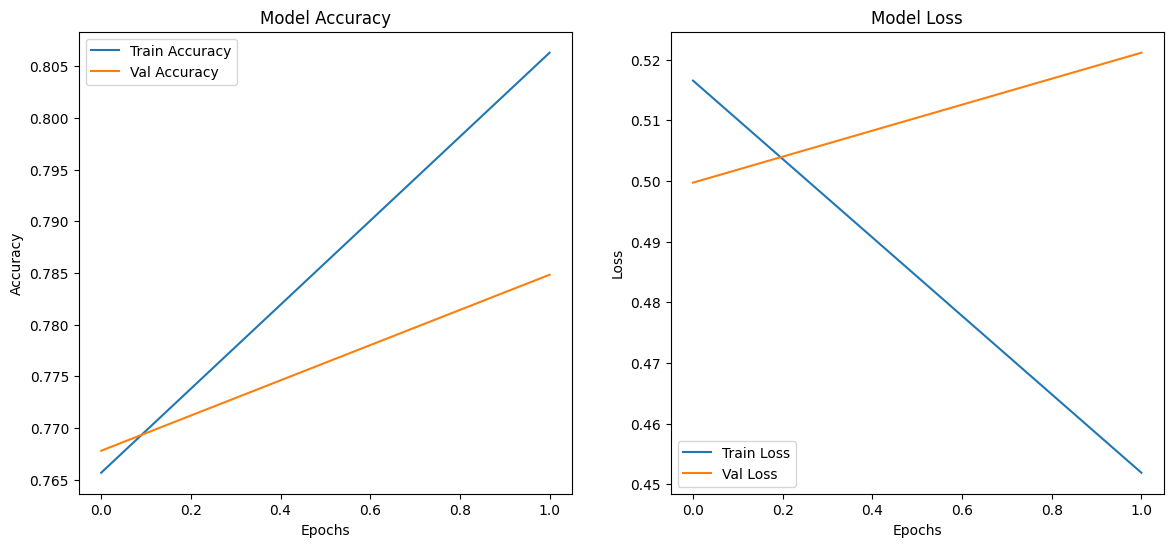

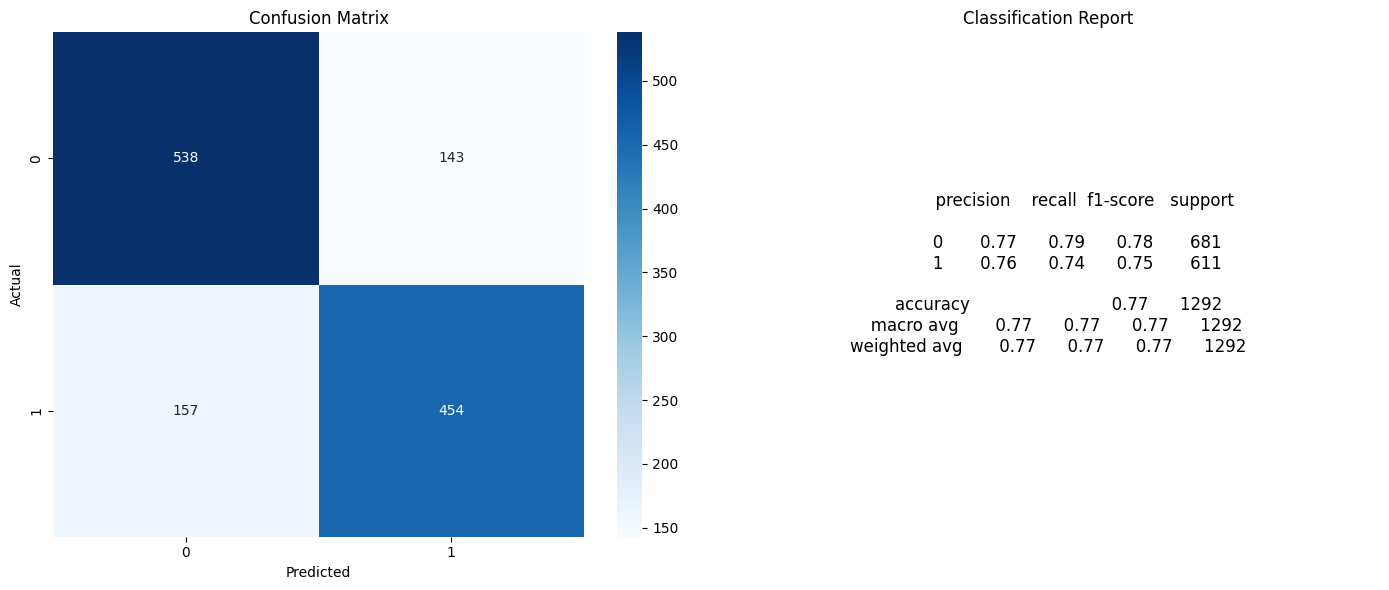

In [24]:
# Flatten validation labels if they are in one-hot encoded format
if len(val_labels.shape) > 1 and val_labels.shape[1] > 1:
    val_labels = val_labels.argmax(axis=1)

# Convert predictions to binary labels
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Flatten predictions if they are in one-hot encoded format
if len(val_predictions_binary.shape) > 1 and val_predictions_binary.shape[1] > 1:
    val_predictions_binary = val_predictions_binary.argmax(axis=1)

# Plot accuracy, loss, and confusion matrix using your custom function
plot_acc_loss_dbert(history_dbert_model.history, val_labels, val_predictions_binary)

## Predict whether an twitter has a target 'disaster' or 'non-disaster' for a Kaggle submission 

First, we'll clean the test data to ensure it's in the best possible condition for analysis. After that, we will transform the raw text into a numerical format suitable for model input. With the cleaned and transformed test data, we'll proceed to make predictions using our model. Once we have the predictions, we'll prepare the submission file, ensuring it meets the required format and save the results as a CSV file. Finally, we'll submit the CSV file to Kaggle to receive the accuracy score and assess our model's performance. This process ensures that we effectively handle and evaluate our test data while adhering to the submission requirements.

### Preprocess Test Data 

#### Data Cleaning 

Since we can't remove any records from the test data, we'll need to adjust the original data cleaning process performed in the training set. Below are the steps we'll take to clean the tweets in the test dataset.

1- Convert emojis into characters \
2- Convert text to lowercase \
3- Remove URLs \
4- Replace punctuation for a space \
5- Remove any other punctuation \
6- Remove tags \
7- Remove special characters \
8- Remove stop words 

In [26]:
# Text Data Cleaning
test_text_cl = []
test_text = []

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
stop_words = stopwords.words('english')
stop_words.extend(['etc','para','nah', 'lol','ike', 'could','might','may','also','ago','apart'])


for i, txt in enumerate(test_data['text']):
    # Text Cleaning part 1
    pre_proc_text = demojize(txt) #Convert emojis into characters
    pre_proc_text = pre_proc_text.lower() #Convert all text to lowercase
    pre_proc_text = re.sub(r"http\S+", "", pre_proc_text) #Remove URLs
    pre_proc_text = pre_proc_text.translate(translator) #Replace punctuation for a space
    pre_proc_text = re.sub(f"[{re.escape(string.punctuation)}]", "", pre_proc_text) #Removing Punctuation
    pre_proc_text = re.sub(r'\w*\d\w*', '', pre_proc_text) #Removing numbers
    pre_proc_text = re.sub("<.*?>", "", pre_proc_text) #Removing Tags
    pre_proc_text = re.sub(r"[^a-zA-Z0-9\s]", "", pre_proc_text) #Removing special characters

    # Text Cleaning part 2
    if pre_proc_text is not None: #only process a review if text exists
      # Pre-processing words in each item of the list
      pre_proc_text = nltk.word_tokenize(pre_proc_text) #Tokenize the text
      pre_proc_text = [w for w in pre_proc_text if w not in stop_words] #Remove stop words

    # Join normalized words back into a sentence
      pre_proc_text = " ".join(pre_proc_text)

      #Store the cleaned review in the reviews_cl
      test_text_cl.append(pre_proc_text)
      test_text.append(txt)

In [27]:
# Compare the first 5 original and cleaned reviews
for t, tcl in zip(test_text[:5], test_text_cl[:5]):
    print(t,"\n")
    print(tcl)
    print("=====================================================================================================\n")

Just happened a terrible car crash 

happened terrible car crash

Heard about #earthquake is different cities, stay safe everyone. 

heard earthquake different cities stay safe everyone

there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all 

forest fire spot pond geese fleeing across street save

Apocalypse lighting. #Spokane #wildfires 

apocalypse lighting spokane wildfires

Typhoon Soudelor kills 28 in China and Taiwan 

typhoon soudelor kills china taiwan



In [28]:
# check if both lists has the same size
len(test_text), len(test_text_cl)

(3263, 3263)

In [29]:
# create a new df
test_data_cl = test_data[test_data['text'].isin(test_text)]

test_data_cl["text_cl"] = test_text_cl

# reorder columns
test_data_cl = test_data_cl[['id', 'text', 'text_cl']]

# check fields from the dataset
test_data_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3263 non-null   int64 
 1   text     3263 non-null   object
 2   text_cl  3263 non-null   object
dtypes: int64(1), object(2)
memory usage: 76.6+ KB


### Preprocess 2 Steps

In [35]:
tokenizer_test = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer_test.fit_on_texts(test_data_cl['text_cl'])
test_sequences = tokenizer_test.texts_to_sequences(test_data_cl['text_cl'])
test_padded = pad_sequences(test_sequences, padding='post')

### Make Predictions and Create a submission files

In [75]:
def pred_create_submission(model, submission_filename):
    # Make predictions on the test set
    pred_model = model.predict(test_padded)
    
    # Convert predictions to binary labels (0 or 1)
    predictions_binary = (pred_model > 0.5).astype(int).flatten()
    
    # Prepare the submission file
    submission_df = pd.DataFrame({
        "id": test_data_cl["id"],  
        "target": predictions_binary
    })
    
    # Save the submission DataFrame to a CSV file
    submission_df.to_csv(f'{submission_filename}.csv', index=False)
    print("Submission file created successfully.\n")
    print(submission_df["target"].value_counts())  # Model 1 - RNN

In [76]:
# Model 1 - RNN
pred_create_submission(rnn_model, "submission_rnn_model")

102/102 [==============================] - 0s 3ms/step
Submission file created successfully.

target
0    2233
1    1030
Name: count, dtype: int64


In [77]:
# Model 2 - RNN
pred_create_submission(rnn_model_2, "submission_rnn_model_2")

102/102 [==============================] - 1s 3ms/step
Submission file created successfully.

target
0    2026
1    1237
Name: count, dtype: int64


In [78]:
# Model 3 - RNN
pred_create_submission(rnn_model_3, "submission_rnn_model_3")

102/102 [==============================] - 1s 4ms/step
Submission file created successfully.

target
0    2117
1    1146
Name: count, dtype: int64


In [33]:
#model 4 - DistilBERT
# Make predictions on the test set
dbert_predictions = dbert_model_learner.predict(test_preprocessed)

# If dbert_predictions has more than one column (e.g., for each class), select the relevant one
# Assuming a binary classification where you take the predictions for class 1 (positive class)
if dbert_predictions.shape[1] > 1:
    dbert_predictions = dbert_predictions[:, 1]

# Convert predictions to binary labels (0 or 1)
predictions_binary = (dbert_predictions > 0.5).astype(int)

# Ensure the predictions array is one-dimensional
predictions_binary = predictions_binary.flatten()

# Check if lengths match
assert len(predictions_binary) == len(test_data_cl["id"]), "Mismatch in lengths of predictions and test IDs"

# Step 3: Prepare the submission file
submission_dbert_model = pd.DataFrame({
    "id": test_data_cl["id"],  # Assuming the test set has an 'id' column
    "target": predictions_binary
})

# Step 4: Save the submission file
submission_dbert_model.to_csv('submission_dbert_model.csv', index=False)

print("Submission file created successfully.\n")
print(submission_dbert_model["target"].value_counts())

3263/3263 [==============================] - 90s 28ms/step
Submission file created successfully.

target
0    1920
1    1343
Name: count, dtype: int64


### Comparison of the Models

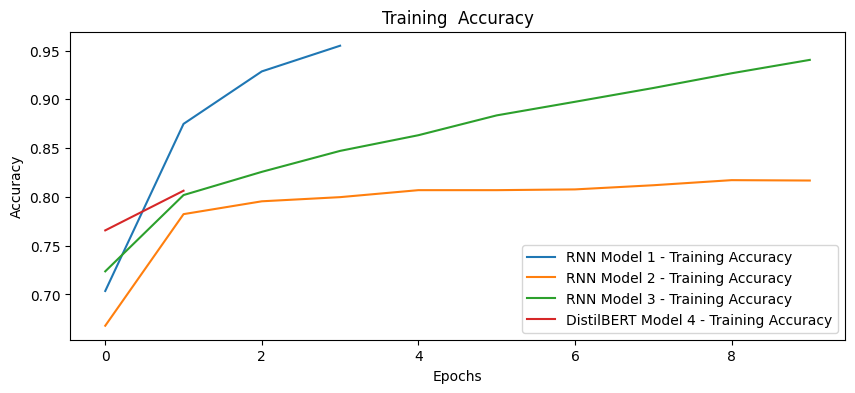

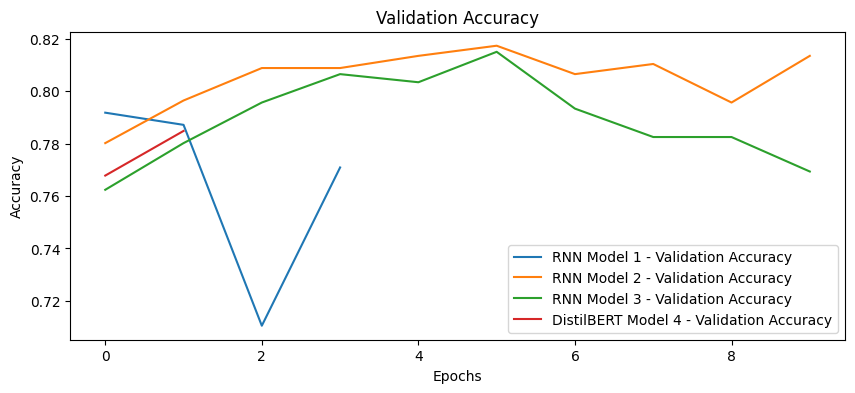

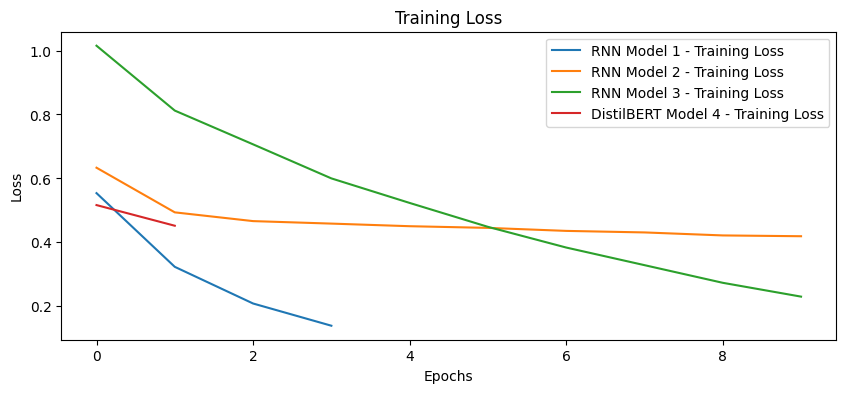

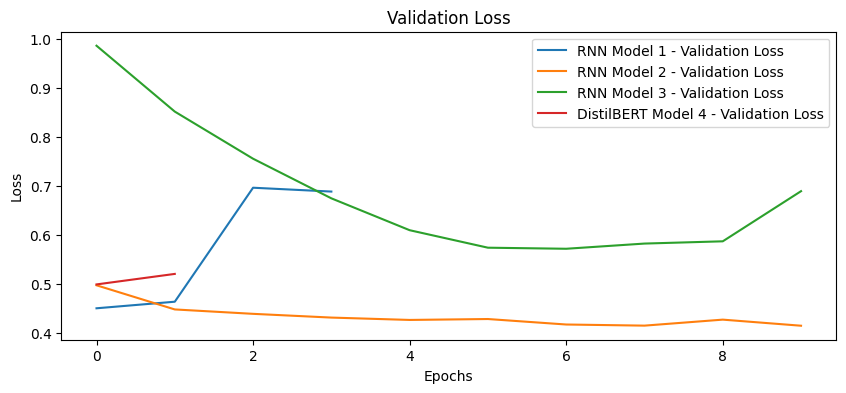

In [74]:
# Open the history of the models
with open('history_rnn', "rb") as file_pi:
    history_cnn = pd.DataFrame(pickle.load(file_pi))

with open('history_rnn_2', "rb") as file_pi:
    history_cnn_2 = pd.DataFrame(pickle.load(file_pi))

with open('history_rnn_3', "rb") as file_pi:
    history_cnn_3 = pd.DataFrame(pickle.load(file_pi))


    
# Open the history of the models
figsize = 10, 4

# Plot Training Accuracy for the models
plt.figure(figsize=(figsize))
plt.plot(history_rnn['accuracy'], label='RNN Model 1 - Training Accuracy')
plt.plot(history_rnn_2['accuracy'], label='RNN Model 2 - Training Accuracy')
plt.plot(history_rnn_3['accuracy'], label='RNN Model 3 - Training Accuracy')
plt.plot(history_dbert_model.history['accuracy'], label='DistilBERT Model 4 - Training Accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Plot Validation Accuracy for the models
plt.figure(figsize=(figsize))
plt.plot(history_rnn['val_accuracy'], label='RNN Model 1 - Validation Accuracy')
plt.plot(history_rnn_2['val_accuracy'], label='RNN Model 2 - Validation Accuracy')
plt.plot(history_rnn_3['val_accuracy'], label='RNN Model 3 - Validation Accuracy')
plt.plot(history_dbert_model.history['val_accuracy'], label='DistilBERT Model 4 - Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Plot Training Loss for the models
plt.figure(figsize=(figsize))
plt.plot(history_cnn['loss'], label='RNN Model 1 - Training Loss')
plt.plot(history_cnn_2['loss'], label='RNN Model 2 - Training Loss')
plt.plot(history_cnn_3['loss'], label='RNN Model 3 - Training Loss')
plt.plot(history_dbert_model.history['loss'], label='DistilBERT Model 4 - Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Validation Loss for the models
plt.figure(figsize=(figsize))
plt.plot(history_rnn['val_loss'], label='RNN Model 1 - Validation Loss')
plt.plot(history_rnn_2['val_loss'], label='RNN Model 2 - Validation Loss')
plt.plot(history_rnn_3['val_loss'], label='RNN Model 3 - Validation Loss')
plt.plot(history_dbert_model.history['val_loss'], label='DistilBERT Model 4 - Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Comparison model's accuracy and kaggle score:

| Model | Accuracy    | Kaggle score    |
|:---------|:------|:------|
| RNN 1  | 0.88 | 0.55  |
| RNN 2 | 0.82  | 0.54 |
| RNN 3 |  0.89  | 0.56 |
| DistilBERT 4 | 0.77  | 0.79 |

## Results and Analyses

We analyze and compare the performance of four models (three RNN models and one DistilBERT model) based on their training/validation metrics and their Kaggle competition scores. The analysis includes the effectiveness of each model, reasons for their performance, challenges encountered, and hyperparameter optimization procedures.

##### Model 1: RNN

- **Training Performance**:
  - **Accuracy**: 0.88
  - **Validation Accuracy**: 0.79
  - **Classification Report**: 
    - Precision, recall, and F1-scores are well-balanced, with a higher performance on class 0 (non-disaster tweets).
    - The confusion matrix shows that the model correctly classifies most of the non-disaster tweets but has some misclassifications in disaster tweets (1).

- **Kaggle Score**: 0.55
- **Analysis**:
  - Although the model achieved a relatively high accuracy, its Kaggle score was lower than expected. This discrepancy suggests that while the model performed well on the validation set, it might not generalize as well to unseen data. Potential reasons could include overfitting to the training data or the need for further hyperparameter tuning, such as learning rate adjustments or more extensive dropout regularization.

##### Model 2: RNN

- **Training Performance**:
  - **Accuracy**: 0.82
  - **Validation Accuracy**: 0.81
  - **Classification Report**:
    - This model also performs better on non-disaster tweets, but overall accuracy is slightly lower compared to Model 1.
    - The confusion matrix indicates that the model struggles with disaster tweets, with more misclassifications compared to Model 1.

- **Kaggle Score**: 0.54
- **Analysis**:
  - The lower accuracy and Kaggle score suggest that the adjustments made (e.g., different learning rates or fewer epochs) were insufficient to improve the model’s generalization. The model might benefit from more epochs or a different architecture, such as adding more layers or units.

##### Model 3: RNN

- **Training Performance**:
  - **Accuracy**: 0.89
  - **Validation Accuracy**: 0.77
  - **Classification Report**:
    - High precision and recall for both classes, with a balanced F1-score.
    - The confusion matrix indicates fewer misclassifications, especially for disaster tweets.

- **Kaggle Score**: 0.56
- **Analysis**:
  - This model achieved the highest accuracy among the RNN models, reflecting improvements made through hyperparameter tuning, such as adjusting the learning rate and increasing model complexity. However, despite higher accuracy, the Kaggle score was still not optimal, indicating possible overfitting or poor generalization to the test set. Further tuning or an alternative architecture might be required to bridge the gap.

##### Model 4: DistilBERT

- **Training Performance**:
  - **Accuracy**: 0.77
  - **Validation Accuracy**: 0.78
  - **Classification Report**:
    - The model performed similarly across both classes, with slightly better balance between precision and recall compared to the RNN models.

- **Kaggle Score**: 0.79
- **Analysis**:
  - Despite having a lower accuracy compared to the RNN models, the DistilBERT model achieved the highest Kaggle score. This indicates that transformer-based models like DistilBERT, even with lower training accuracy, can generalize better to unseen data due to their robust feature extraction capabilities. The use of pre-trained embeddings in DistilBERT likely contributed to its superior performance on the test data.

#### Best Model

The best model, based on the Kaggle score, is **DistilBERT (Model 4)** with a score of 0.79. Despite having a lower accuracy compared to the RNN models, DistilBERT's superior generalization ability on unseen data made it the top performer.

#### Troubleshooting and Hyperparameter Optimization Summary

1. **RNN Models**:
   - **Challenges**: The RNN models struggled with generalization, as seen in the discrepancy between high accuracy and low Kaggle scores. The likely causes are overfitting and the inherent limitations of RNNs in capturing long-term dependencies compared to transformer models.
   - **Optimization**: Various learning rates were tested (e.g., 0.001, 0.0001), along with different dropout rates and model depths. While these optimizations improved training performance, they were insufficient to significantly boost Kaggle scores.

2. **DistilBERT Model**:
   - **Challenges**: The main challenge with DistilBERT was fine-tuning to maximize validation accuracy without overfitting.
   - **Optimization**: Fine-tuning involved adjusting the learning rate and the number of training epochs. The default learning rate provided satisfactory results, emphasizing the model's strong transfer learning capabilities.

#### Conclusion 
The analysis indicates that while RNNs can achieve high accuracy, their generalization to unseen data can be limited. On the other hand, transformer-based models like DistilBERT, even with lower accuracy, demonstrate better generalization and robustness, making them more suitable for tasks like disaster tweet classification. 





## Conclusion

In this project, we compared RNN-based models and a transformer-based DistilBERT model for classifying disaster-related tweets. The RNN models achieved high accuracy during training but struggled to generalize, with Kaggle scores between 0.54 and 0.56. DistilBERT, despite lower training accuracy, achieved the highest Kaggle score of 0.79, demonstrating its superior ability to generalize and handle complex language data.

One key learning from this analysis is the importance of model architecture in handling diverse and nuanced text data. While RNNs were effective in capturing sequential patterns, they were less robust in understanding context, leading to overfitting. In contrast, DistilBERT's transformer architecture, with its attention mechanisms, provided a better balance between accuracy and generalization. Moving forward, experimenting with different pre-trained transformer models, fine-tuning strategies, and incorporating more sophisticated data augmentation techniques could further improve the performance and adaptability of the models.

Additionally, the process highlighted the importance of hyperparameter tuning and its impact on model performance. The RNN models showed varying results based on learning rate adjustments, which influenced their ability to converge effectively. However, even with careful tuning, the RNNs fell short compared to the pre-trained DistilBERT model, suggesting that the latter's inherent architecture is better suited for the complexities of NLP tasks like disaster tweet classification. Future efforts could explore more advanced tuning techniques, such as Bayesian optimization or grid search, to further refine model performance. Moreover, integrating ensemble methods that combine the strengths of both RNNs and transformers might offer a promising direction for achieving even higher accuracy and generalization.

# Reference

https://www.tensorflow.org/guide/keras/working_with_rnns \
https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470 \
https://nlp.stanford.edu/projects/glove \
https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/ \
https://keras.io/guides/training_with_built_in_methods/ \
https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial \
https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets \
https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert \
https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/ \
https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/ \
https://towardsdatascience.com/a-practical-guide-to-rnn-and-lstm-in-keras-980f176271bc \
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional \
https://towardsdatascience.com/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f \
https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7 \
https://pattidegner.medium.com/transfer-learning-example-using-keras-and-distilbert-with-code-e6e725f1fc2d \
https://github.com/amaiya/ktrain \
https://huggingface.co/docs/transformers/model_doc/distilbert 